# Régression logistique

## Le neurone artificiel

Il est temps de passer aux choses sérieuses et de présenter le neurone articifiel. 

La figure ci-dessous montre le fonctionnement d'un neurone artificiel : 

![Neurone artificiel](./images/NeuroneArtificiel.png)

Le neurone artificiel prend en entrée un vecteur $\mathbf{x}=(x_1,x_2,...,x_n)$, chaque élément $x_i$ du vecteur $\mathbf{x}$ est ensuite multiplié par un poids $w_i$ puis on somme l'ensemble et on ajoute un biais $b$. Cette somme est ensuite passé dans une fonction qu'on appelle **fonction d'activation** $\phi$.  
$Sortie = \phi(\sum_{i=0}^{n} w_i x_i  + b)$  
On appelle ce procédé neurone artificiel par analogie avec le fonctionnement d'un [neurone biologique](https://en.wikipedia.org/wiki/Artificial_neuron).  

## Les fonctions d'activation

**Fonction de Heaviside :** A l'origine, le premier neurone articiel ([le perceptron](https://fr.wikipedia.org/wiki/Perceptron)) utilisait une fonction de seuillage comme fonction d'activation. Cela permet de prendre une décision (0 ou 1) par rapport à la somme pondérée et un seuil défini.  
$heaviside(x) = \left\{
    \begin{array}{ll}
        1 & \text{si } x > 0 \\
        0 & \text{sinon}
    \end{array}
\right. \text{avec } x=\sum_{i=0}^{n} w_i x_i  + b$  
Cette fonction d'activation est efficace pour obtenir une classification binaire mais elle ne fonctionne pas pour plusieurs classes. De plus, la fonction n'est pas dérivable, il est donc compliqué d'utiliser l'algorithme de la descente du gradient pour optimiser les poids $w_i$ du neurone.  

Les fonctions d'activation récente sont beaucoup plus intéressante pour l'entraînement de réseaux de neurones par descente du gradient. Premièrement, on choisit des fonctions dérivables ce qui permet d'appliquer notre algorithme de descente du gradient. Deuxièmement, on choisit des fonctions non-linéaire ce qui permet aux réseaux d'apprendre des représentations complexes. Il y a également d'autres avantages spécifiques à chaque fonction d'activation.   

Une des fonctions d'activation "récente" est la fonction sigmoïde que nous détaillons ici : 

**Fonction sigmoïde :** Une autre fonction d'activation particulièrement intéressante par son analogie avec une probabilité est la fonction sigmoïde. Cette fois-ci, la fonction va permettre d'obtenir une valeur entre 0 et 1 par la formule :  
$sigmoid(x) = \frac{1}{1 + e^{-x}} \text{ avec } x=\sum_{i=0}^{n} w_i x_i  + b$

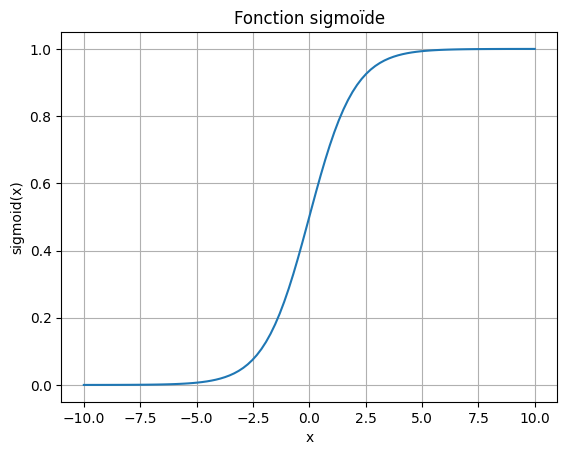

In [1]:
# Tracé de la fonction sigmoïde
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
x = np.linspace(-10, 10, 100)
y = sigmoid(x)

plt.plot(x, y)
plt.title('Fonction sigmoïde')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.grid(True)
plt.show()

Cette fonction est dérivable et sa dérivée vaut :  
$sigmoid'(x) = sigmoid(x) \cdot (1 - f(x))$  
On peut donc appliquer la descente du gradient sur notre neurone artificiel lorsqu'on utilise cette fonction d'activation.

Il existe de nombreuses autres [fonctions d'activations](https://fr.wikipedia.org/wiki/Fonction_d%27activation) qui ont chacune leurs utilités que nous verrons dans les cours suivants. ($Tanh$,$ReLU$,$Softmax$)


## Application

Pour comprendre la régression logistique, le mieux est de passer par un exemple d'application.  
Dans cet exemple, nous allons déterminer si un étudiant va être admis dans l'université de ses rêves à partir de trois informations : son score à l'examen d'entrée, ses notes moyennes de l'année précédente et la qualité de sa lettre de motivation.  
Nous n'avons pas accès à la méthode de calcul pour l'admission ou non d'un étudiant mais nous disposons de données et de la décision correspondantes.  
Les informations d'entrée sont entre 0 et 1, avec 1 indiquant le meilleur score. Admis = 1 correspond à une admission tandis qu'admis = 0 correspond à un refus.   
Nous disposons des informations suivantes :  

In [2]:
from tabulate import tabulate

# Définition des données d'entraînement
values_train = [[0.7, 0.8, 0.1], [0.4, 0.9, 0.5], [0.2, 0.3, 0.9], [0.9, 0.9, 0.6]]
labels_train = [1, 0, 0, 1]

# Ajout des noms de colonnes
data = [['Examen', 'Moyenne', 'Motivation', 'Admis']]
data.extend([[values_train[i][0], values_train[i][1], values_train[i][2], labels_train[i]] for i in range(len(values_train))])

# Affichage du tableau
print(tabulate(data, headers="firstrow", tablefmt="fancy_grid"))

╒══════════╤═══════════╤══════════════╤═════════╕
│   Examen │   Moyenne │   Motivation │   Admis │
╞══════════╪═══════════╪══════════════╪═════════╡
│      0.7 │       0.8 │          0.1 │       1 │
├──────────┼───────────┼──────────────┼─────────┤
│      0.4 │       0.9 │          0.5 │       0 │
├──────────┼───────────┼──────────────┼─────────┤
│      0.2 │       0.3 │          0.9 │       0 │
├──────────┼───────────┼──────────────┼─────────┤
│      0.9 │       0.9 │          0.6 │       1 │
╘══════════╧═══════════╧══════════════╧═════════╛


Notre but dans ce problème est de déterminer si les étudiants ayant eu les scores $[Examen=0.8, Moyenne=0.7, Motivation=0.2]$ et $[Examen=0.4, Moyenne=0.5, Motivation=0.9]$ ont été admis. 

Vous l'aurez compris, les données $Examen$, $Moyenne$ et $Motivation$ correspondent à nos $x_i$. Notre but avec la régression logistique est de trouver une valeur optimale des $w_i$ en concordance avec nos données d'entrainement.   
Par simplicité, posons $x_0=Examen$, $x_1=Moyenne$ et $x_2=Motivation$ et $y_{true}=Admis$.  

### Fonction de coût

Dans notre exemple de descente du gradient, notre but était de trouver le minimum d'une fonction. C'est dans ces scénarios que la descente du gradient excelle. Pour notre nouveau problème, il nous faut trouver une fonction qui, lorsqu'on la minimise, améliore les prédictions.  
Dans notre classification binaire, $y_{true}$ vaut 1 si l'élève est admis et 0 sinon.  
Notre but est de prédire si l'élève est admis ou non en prédisant la sortie $pred$.  
Lors de l'entraînement, on veut entraîner notre modèle de régression logistique à prédire $ pred \approx y_{true}$. 
Pour cela, on utilise la fonction de vraisemblance négative qui s'exprime de la manière suivante :   
$\text{loss} = - \left( y_{\text{true}} \cdot \log(\text{pred}) + (1 - y_{\text{true}}) \cdot \log(1 - \text{pred}) \right)$

Pour plus de détails sur la régression logistique et la perte de vraisemblance négative, vous pouvez consulter ce [lien](https://blog.demir.io/understanding-logistic-regression-26802c0da856).

L'important est de comprendre comment varie cette fonction en fonction de notre prédiction $pred$ et du label $y_{true}$.  
Pour cela, prenons le cas où le label est $y_{true}=1$. Analysons deux cas :  
Si $pred=0.9$, c'est-à-dire que notre modèle prédit que l'élève sera admis à 90% de chance ce qui est une bonne prédiction alors :  
$\text{loss} = - \left( 1.0 \cdot \log(0.9) + (1 - 1.0) \cdot \log(1 - 0.9) \right)$  
$\text{loss} = - \left( 1.0 \cdot \log(0.9) + 0 \cdot \log(1 - 0.9) \right)$  
$\text{loss} = - \left( 1.0 \cdot \log(0.9)\right)$   
$\text{loss} = - \left( 1.0 \cdot \log(0.9)\right)$  
$\text{loss} = 0.046$   
Le loss est faible, c'est une bonne chose car la prédiction est bonne.

Si $pred=0.2$, c'est-à-dire que notre modèle prédit que l'élève sera admis à 20% de chance ce qui est une mauvaise prédiction alors :  
$\text{loss} = - \left( 1.0 \cdot \log(0.2) + (1 - 1.0) \cdot \log(1 - 0.2) \right)$  
$\text{loss} = - \left( 1.0 \cdot \log(0.2) + 0 \cdot \log(1 - 0.2) \right)$  
$\text{loss} = - \left( 1.0 \cdot \log(0.2)\right)$   
$\text{loss} = - \left( 1.0 \cdot \log(0.2)\right)$  
$\text{loss} = 0.70$   
Le loss est important, c'est une bonne chose car la prédiction est mauvaise.

Pour un cas où $y_{true}=0$, on retrouve un loss faible quand la $pred$ est proche 0 et un loss important quand $pred$ est proche de 1 (faire le calcul pour s'exercer si besoin). 

### Calcul des dérivées

Maintenant que l'on dispose d'une fonction à minimiser, il est nécessaire de calculer la dérivée de cette fonction en fonction de chacun des poids $w_0$, $w_1$, $w_2$ et $b$. 
On doit donc calculer $\frac{\partial loss}{\partial w_0}$, $\frac{\partial loss}{\partial w_1}$, $\frac{\partial loss}{\partial w_2}$ et $\frac{\partial loss}{\partial b}$. 
Pour les poids $w_0$, $w_1$ et $w_2$, la dérivée s'effectue de la même manière.  
Avec la règle de la chaîne, pour $w_0$, on a : 
$\frac{\partial loss}{\partial w_0} = \frac{\partial loss}{\partial pred} \cdot \frac{\partial pred}{\partial w_0}$   

Pour rappel, notre prédiction $pred$ correspond à la sortie de notre régression logistique avec la fonction d'activation $sigmoid$. 

Pour le premier terme, la dérivée du loss en fonction de pred nous donne :  
$\frac{\partial loss}{\partial pred} = -(\frac{y_{true}}{pred} - \frac{1-y_{true}}{1-pred}) $  
Le calcul ne sera pas détaillé ici mais vous pouvez le faire vous-même pour vous en assurer.  

Pour le second terme, la dérivée de pred en fonction de $w_0$ nous donne :    
$\frac{\partial pred}{\partial w_0} = pred \cdot (1-pred) \cdot x_0$

En combinant les deux termes, on obtient :  
$\frac{\partial loss}{\partial w_0} =-(\frac{y_{true}}{pred} - \frac{1-y_{true}}{1-pred}) \cdot pred \cdot (1-pred) \cdot x_0$  

Et après simplification (magique),  
$\frac{\partial loss}{\partial w_0} = (pred-y_{true}) \cdot x_0$  

Sans détailler le calcul, on obtient également :  
$\frac{\partial loss}{\partial b} = pred-y_{true}$ 

### Régression logistique

Maintenant que l'on a tous les éléments, 
définissons notre fonction de regression logistique en python :

In [3]:
# Notre classe de regression logistique
class logistic_regression():
  def __init__(self) -> None:
    self.w0=np.random.randn()
    self.w1=np.random.randn()
    self.w2=np.random.randn()
    self.b=0
  def __call__(self,x0,x1,x2):
    # Somme pondérée et ajout du biais
    pond=self.w0*x0+self.w1*x1+self.w2*x2+self.b
    # Application de la sigmoïde
    pred=sigmoid(pond)
    return pred
    
def loss(y_true, y_pred):
  # Calcul du loss (log vraisemblance négative)
  loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
  return loss
    

def update_weights(model,pred, x0, x1, x2, y_true, learning_rate):
       
  # On calcule les dérivées en fonction des poids et du biais 
  dL_dw0 = (pred - y_true) * x0
  dL_dw1 = (pred - y_true) * x1
  dL_dw2 = (pred - y_true) * x2
  dL_db = pred - y_true
      
  # On modifie les paramètres pour réduire le loss 
  # La modification des poids dépend du learning rate, du signe de la dérivée et de la valeur de la dérivée
  model.w0 -= learning_rate * dL_dw0
  model.w1 -= learning_rate * dL_dw1
  model.w2 -= learning_rate * dL_dw2
  model.b -= learning_rate * dL_db

In [4]:

# Initialisation du modèle et des hyperparamètres
learning_rate = 0.01
epochs = 1000 # le nombre d'itérations d'entrainement
model = logistic_regression()

Avant d'entraîner le modèle, testons nos prédictions sur les deux élèves dont on désire connaître le résultat de l'admission.

In [5]:
values_test=[[0.8,0.7,0.7],[0.4,0.5,0.9]]
for value in values_test:
  x0,x1,x2=value
  pred = model(x0, x1, x2)
  print("L'élève avec Examen = "+str(x0)+ ", Moyenne = "+str(x1)+" et Motivation = "+str(x2)+ " a "+str(round(pred*100)) + "% de chance d'être admis")

L'élève avec Examen = 0.8, Moyenne = 0.7 et Motivation = 0.7 a 60% de chance d'être admis
L'élève avec Examen = 0.4, Moyenne = 0.5 et Motivation = 0.9 a 59% de chance d'être admis


On voit que le modèle est très incertain et qu'il donne des probabilités au hasard ce qui est logique car ses poids sont initialisés aléatoirement.  
Maintenant, entrainons le modèle sur nos données d'entrainement. 

In [9]:
# Entraînement
for epoch in range(epochs):
  # Mise à jour des poids pour chaque exemple
  total_loss = 0
  for (x0, x1, x2), y_true in zip(values_train, labels_train):
    pred = model(x0, x1, x2)
    update_weights(model,pred, x0, x1, x2, y_true, learning_rate)
    total_loss += loss(y_true, pred)

  avg_loss = total_loss / len(labels_train)
  
  # Affichage de la perte pour suivre la progression de l'entraînement
  if ((epoch + 1) % 5000 == 0) or (epoch==0):
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

Epoch 1/40000, Loss: 0.01468091027998586
Epoch 5000/40000, Loss: 0.013032955086147595
Epoch 10000/40000, Loss: 0.011715352279809266
Epoch 15000/40000, Loss: 0.010638348324912276
Epoch 20000/40000, Loss: 0.009741762611763436
Epoch 25000/40000, Loss: 0.008983896958517028
Epoch 30000/40000, Loss: 0.008334957514714105
Epoch 35000/40000, Loss: 0.007773096000082178
Epoch 40000/40000, Loss: 0.007281930357182074


In [10]:
print(model.w0, model.w1, model.w2, model.b)

for value in values_test:
  x0,x1,x2=value
  pred = model(x0, x1, x2)
  print("L'élève avec Examen = "+str(x0)+ ", Moyenne = "+str(x1)+" et Motivation = "+str(x2)+ " a "+str(round(pred*100)) + "% de chance d'être admis")

19.464301071981186 -3.27230109363944 -8.244865180820856 -4.903197398150705
L'élève avec Examen = 0.8, Moyenne = 0.7 et Motivation = 0.7 a 93% de chance d'être admis
L'élève avec Examen = 0.4, Moyenne = 0.5 et Motivation = 0.9 a 0% de chance d'être admis


Comme on peut le voir, notre modèle est maintenant beaucoup plus confiant des ses prédictions et il nous donne des prédictions cohérentes par rapport aux données d'entrainement. 